In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Mon Aug  5 09:12:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               Off |   00000000:A8:00.0 Off |                    0 |
| N/A   28C    P0             48W /  350W |       1MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1324
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [8]:
# without any combination
AWmodel_2input = SINN(2, 10, 2, 2).to(device)
AWmodel_2input.load_state_dict(torch.load("/home/zxu64/GIT/Multidimensional-SINN/AWmodel_2input.pth"))

<All keys matched successfully>

In [9]:
# training with pdf of sum
AWmodel_2input_Sum = SINN(2, 10, 2, 2).to(device)
AWmodel_2input_Sum.load_state_dict(torch.load("/home/zxu64/GIT/Multidimensional-SINN/AWmodel_2input_Sum.pth"))

<All keys matched successfully>

In [10]:
# training with pdf of diff
AWmodel_2input_Diff = SINN(2, 10, 2, 2).to(device)
AWmodel_2input_Diff.load_state_dict(torch.load("/home/zxu64/GIT/Multidimensional-SINN/AWmodel_2input_Diff.pth"))

<All keys matched successfully>

In [11]:
# training with pdf of 1 pair
AWmodel_2input_1pair = SINN(2, 10, 2, 2).to(device)
AWmodel_2input_1pair.load_state_dict(torch.load("/home/zxu64/GIT/Multidimensional-SINN/AWmodel_2input_1pair.pth"))

<All keys matched successfully>

In [12]:
# training with pdf of 2 pairs
AWmodel_2input_2pair = SINN(2, 10, 2, 2).to(device)
AWmodel_2input_2pair.load_state_dict(torch.load("/home/zxu64/GIT/Multidimensional-SINN/AWmodel_2input_2pair.pth"))

<All keys matched successfully>

In [13]:
# training with pdf of 2 pairs
AWmodel_2input_3pair = SINN(2, 10, 2, 2).to(device)
AWmodel_2input_3pair.load_state_dict(torch.load("/home/zxu64/GIT/Multidimensional-SINN/AWmodel_2input_3pair.pth"))

<All keys matched successfully>

200.0
(1000, 400) (1000, 400)
(400, 400) (400, 400) (400, 400)
(400, 400, 2)
CPU times: user 1.87 s, sys: 6.77 ms, total: 1.88 s
Wall time: 1.89 s


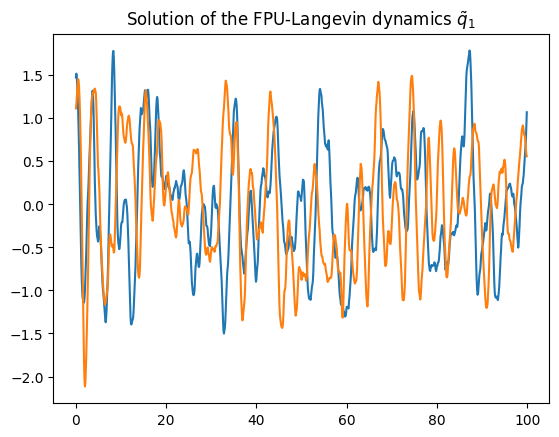

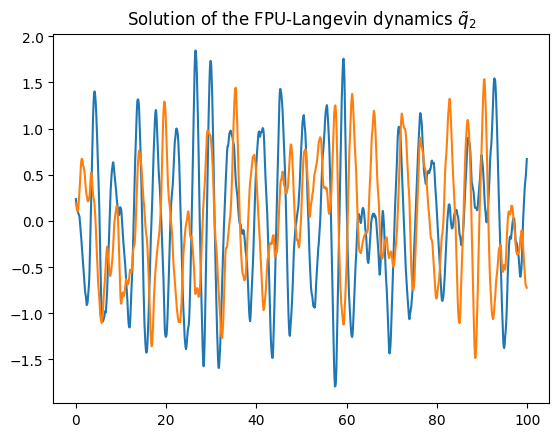

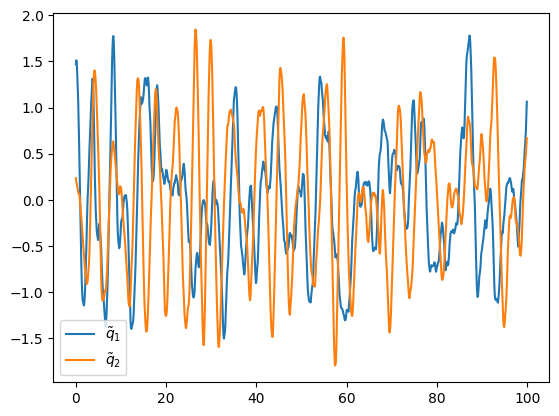

In [14]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


def V_FPU(x,U0,x0):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v


#### Parameters 
gamma1 = 1                             # coupling constant 
gamma2 = .5                            # coupling constant
beta = 1                               # Inverse temperature, i.e. T=1/beta
dt = 0.01                              # Step-size of the SDE solver 
delta_t = 0.1                          # Step-size of the temporally coarse-grained path
batch = 400                           # Batch size 
sec_length = 400                       # Length of the input sequence 
U0 = 1                                 # FPU parameter, depth of the well 
x0 = 1                                 # FPU parameter, position of the basin 
rho = 0.00                             # Correlation of q1 and q2 

#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q1_store = np.zeros([t_store.size+1,batch])
q2_store = np.zeros([t_store.size+1,batch])
# q_store = np.zeros([t_store.size+1,batch])
p1=np.zeros((2,batch))
p2=np.zeros((2,batch))
q1=np.zeros((2,batch))
q2=np.zeros((2,batch))

# solve SDE
j=1
for i in range(1,length):
     q1[1,:] = q1[0,:] + p1[0,:]*dt
     p1[1,:] = p1[0,:] + (-V_FPU(q1[0,:],U0,x0)-gamma1*p1[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma1/beta)
     q2[1,:] = q2[0,:] + p2[0,:]*dt
     p2[1,:] = p2[0,:] + (-V_FPU(q2[0,:],U0,x0)-gamma2*p2[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma2/beta)
     if i % gap ==0:            
            q1_store[j,:]=q1[1,:]
            q2_store[j,:]=rho*q1[1,:]+np.sqrt(1-rho**2)*q2[1,:]
            j=j+1
     p1[0,:]=p1[1,:]
     q1[0,:]=q1[1,:]
     p2[0,:]=p2[1,:]
     q2[0,:]=q2[1,:]

Toss=int(t_store.size/2)         
q1_store=q1_store[Toss:-1,:]         
q2_store=q2_store[Toss:-1,:]    
print(q1_store.shape,q2_store.shape)




plt.figure(0)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,i])
plt.title(r"Solution of the FPU-Langevin dynamics $\tilde{q}_1$")
# plt.savefig("figs/FPU_dt016.pdf", dpi=150)

plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,i])
plt.title(r"Solution of the FPU-Langevin dynamics $\tilde{q}_2$")

plt.figure(2)
plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0], label=r'$\tilde{q}_1$')
plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0], label=r'$\tilde{q}_2$')
# plt.title("Solution of the FPU-Langevin dynamics")
plt.legend()
# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj_q1=q1_store[0:sec_length,:]
Traj_q2=q2_store[0:sec_length,:]
print(ini.shape, Traj_q1.shape, Traj_q2.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj_q1
Traj[:,:,1] = Traj_q2
T=np.arange(len(Traj_q1[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

In [15]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [16]:
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred0,_= AWmodel_2input(ran_input)
Pred1,_= AWmodel_2input_Sum(ran_input)
Pred2,_= AWmodel_2input_Diff(ran_input)
Pred,_= AWmodel_2input_1pair(ran_input)
    
# Test: plot the PDF of sum and difference of two trajectories generated by SINN
rho_data =  StatLoss.gauss_kde2(target, -5, 5, 400, None).cpu()
rho_prediction0 = StatLoss.gauss_kde2(Pred0[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
rho_prediction1 = StatLoss.gauss_kde2(Pred1[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
rho_prediction2 = StatLoss.gauss_kde2(Pred2[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
rho_prediction = StatLoss.gauss_kde2(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()

# Test: 2D PDF contour of target and SINN output
rho2D_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
rho2D_prediction0 = StatLoss.gauss_kde2D(Pred0[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
rho2D_prediction1 = StatLoss.gauss_kde2D(Pred1[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
rho2D_prediction2 = StatLoss.gauss_kde2D(Pred2[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
rho2D_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()

# Training with CCF for second moment

In [17]:
# fig, axs = plt.subplots(2,5, constrained_layout=True, figsize=(20, 8))
# pdf = axs[0,0].plot(x, rho_data.numpy())
# legend = axs[0,0].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0,0].set_ylim(0,0.7)
# axs[0,0].set_title('Target PDF of Sum and Difference')

# pdf = axs[0,1].plot(x, rho_prediction0.numpy())
# legend = axs[0,1].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0,1].set_ylim(0,0.7)
# axs[0,1].set_title('SINN Training without combinations')

# pdf = axs[0,2].plot(x, rho_prediction1.numpy())
# legend = axs[0,2].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0,2].set_ylim(0,0.7)
# axs[0,2].set_title('SINN Training with Sum')

# pdf = axs[0,3].plot(x, rho_prediction2.numpy())
# legend = axs[0,3].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0,3].set_ylim(0,0.7)
# axs[0,3].set_title('SINN Training with Difference')

# pdf = axs[0,4].plot(x, rho_prediction.numpy())
# legend = axs[0,4].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0,4].set_ylim(0,0.7)
# axs[0,4].set_title('SINN Training with Sum and Difference')



# xmin, xmax = -5, 5
# ymin, ymax = -5, 5
# xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
# axs[1,0].set_xlim(xmin, xmax)
# axs[1,0].set_ylim(ymin, ymax)
# cfset = axs[1,0].contourf(xx, yy, rho2D_data.numpy(), cmap='Blues')
# cset = axs[1,0].contour(xx, yy, rho2D_data.numpy(), colors='k')
# axs[1,0].clabel(cset, inline=1, fontsize=10)
# axs[1,0].set_xlabel(r'$\tilde{q}_1$')
# axs[1,0].set_ylabel(r'$\tilde{q}_2$') 
# axs[1,0].set_title('Target PDF Contours')

# cfset = axs[1,1].contourf(xx, yy, rho2D_prediction0.numpy(), cmap='Blues')
# cset = axs[1,1].contour(xx, yy, rho2D_prediction0.numpy(), colors='k')
# axs[1,1].set_xlim(xmin, xmax)
# axs[1,1].set_ylim(ymin, ymax)
# axs[1,1].clabel(cset, inline=1, fontsize=10)
# axs[1,1].set_xlabel(r'$\tilde{q}_1$')
# axs[1,1].set_ylabel(r'$\tilde{q}_2$') 
# axs[1,1].set_title('SINN Training without combinations')

# cfset = axs[1,2].contourf(xx, yy, rho2D_prediction1.numpy(), cmap='Blues')
# cset = axs[1,2].contour(xx, yy, rho2D_prediction1.numpy(), colors='k')
# axs[1,2].set_xlim(xmin, xmax)
# axs[1,2].set_ylim(ymin, ymax)
# axs[1,2].clabel(cset, inline=1, fontsize=10)
# axs[1,2].set_xlabel(r'$\tilde{q}_1$')
# axs[1,2].set_ylabel(r'$\tilde{q}_2$') 
# axs[1,2].set_title('SINN Training with Sum')

# cfset = axs[1,3].contourf(xx, yy, rho2D_prediction2.numpy(), cmap='Blues')
# cset = axs[1,3].contour(xx, yy, rho2D_prediction2.numpy(), colors='k')
# axs[1,3].set_xlim(xmin, xmax)
# axs[1,3].set_ylim(ymin, ymax)
# axs[1,3].clabel(cset, inline=1, fontsize=10)
# axs[1,3].set_xlabel(r'$\tilde{q}_1$')
# axs[1,3].set_ylabel(r'$\tilde{q}_2$') 
# axs[1,3].set_title('SINN Training with Difference')

# cfset = axs[1,4].contourf(xx, yy, rho2D_prediction.numpy(), cmap='Blues')
# cset = axs[1,4].contour(xx, yy, rho2D_prediction.numpy(), colors='k')
# axs[1,4].set_xlim(xmin, xmax)
# axs[1,4].set_ylim(ymin, ymax)
# axs[1,4].clabel(cset, inline=1, fontsize=10)
# axs[1,4].set_xlabel(r'$\tilde{q}_1$')
# axs[1,4].set_ylabel(r'$\tilde{q}_2$') 
# axs[1,4].set_title('SINN Training with Sum and Difference')

# Training without CCF for second moment

Text(0.5, 1.0, 'SINN Training with Sum and Difference')

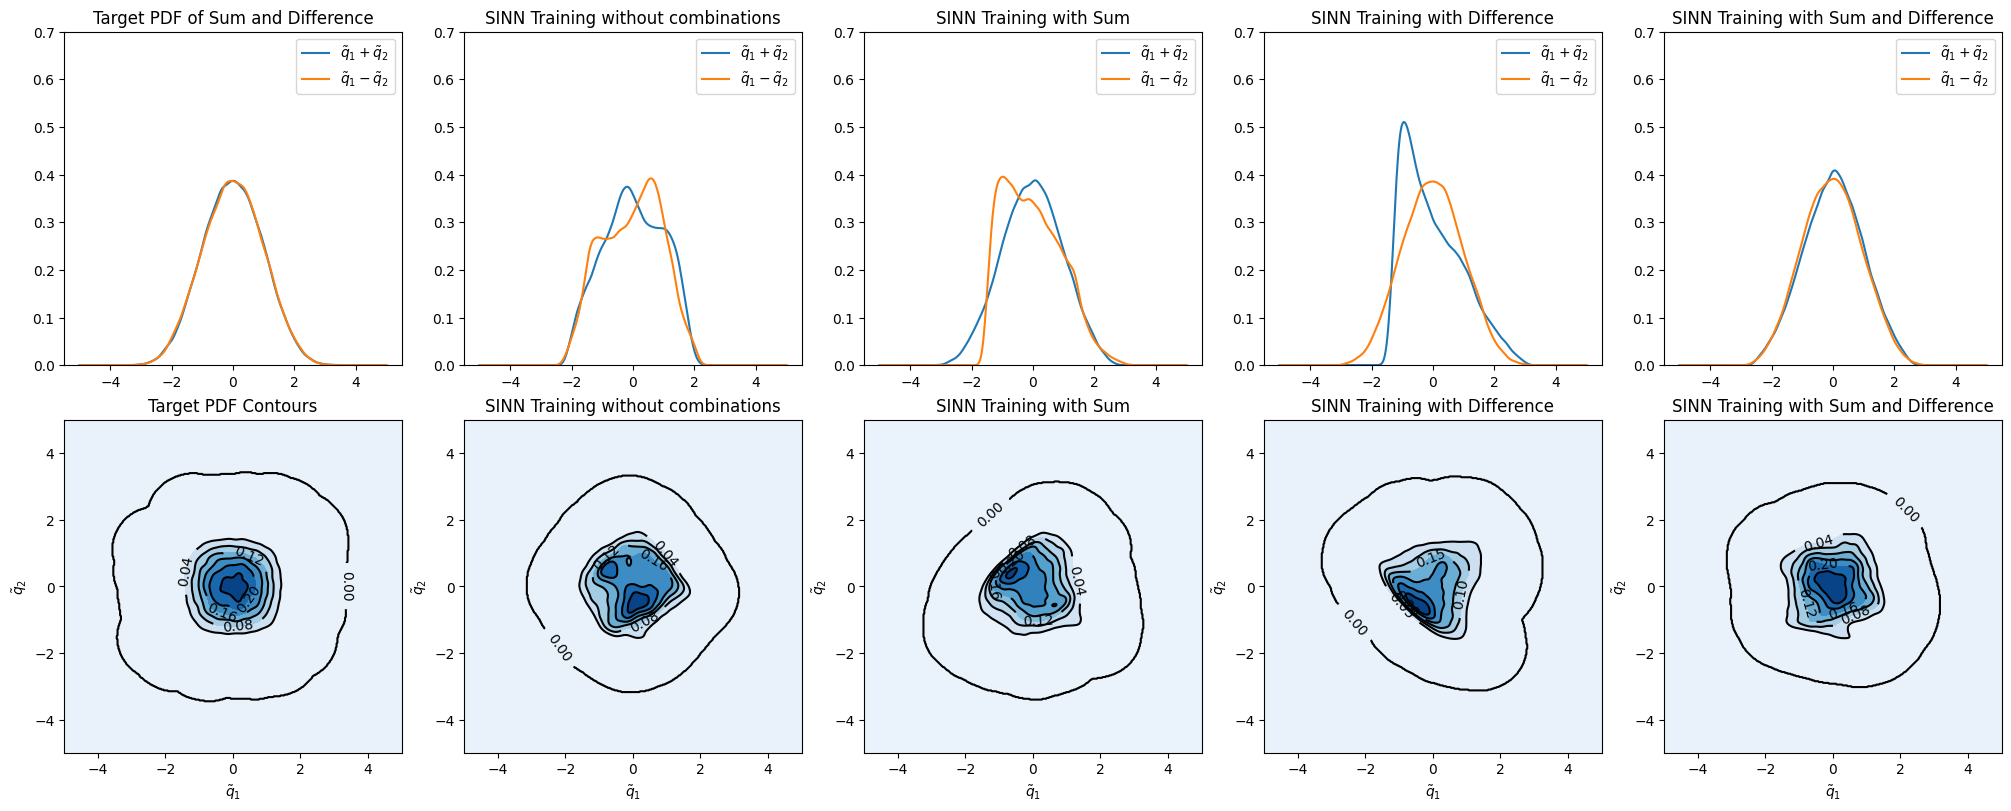

In [18]:
fig, axs = plt.subplots(2,5, constrained_layout=True, figsize=(20, 8))
pdf = axs[0,0].plot(x, rho_data.numpy())
legend = axs[0,0].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
axs[0,0].set_ylim(0,0.7)
axs[0,0].set_title('Target PDF of Sum and Difference')

pdf = axs[0,1].plot(x, rho_prediction0.numpy())
legend = axs[0,1].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
axs[0,1].set_ylim(0,0.7)
axs[0,1].set_title('SINN Training without combinations')

pdf = axs[0,2].plot(x, rho_prediction1.numpy())
legend = axs[0,2].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
axs[0,2].set_ylim(0,0.7)
axs[0,2].set_title('SINN Training with Sum')

pdf = axs[0,3].plot(x, rho_prediction2.numpy())
legend = axs[0,3].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
axs[0,3].set_ylim(0,0.7)
axs[0,3].set_title('SINN Training with Difference')

pdf = axs[0,4].plot(x, rho_prediction.numpy())
legend = axs[0,4].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
axs[0,4].set_ylim(0,0.7)
axs[0,4].set_title('SINN Training with Sum and Difference')



xmin, xmax = -5, 5
ymin, ymax = -5, 5
xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
axs[1,0].set_xlim(xmin, xmax)
axs[1,0].set_ylim(ymin, ymax)
cfset = axs[1,0].contourf(xx, yy, rho2D_data.numpy(), cmap='Blues')
cset = axs[1,0].contour(xx, yy, rho2D_data.numpy(), colors='k')
axs[1,0].clabel(cset, inline=1, fontsize=10)
axs[1,0].set_xlabel(r'$\tilde{q}_1$')
axs[1,0].set_ylabel(r'$\tilde{q}_2$') 
axs[1,0].set_title('Target PDF Contours')

cfset = axs[1,1].contourf(xx, yy, rho2D_prediction0.numpy(), cmap='Blues')
cset = axs[1,1].contour(xx, yy, rho2D_prediction0.numpy(), colors='k')
axs[1,1].set_xlim(xmin, xmax)
axs[1,1].set_ylim(ymin, ymax)
axs[1,1].clabel(cset, inline=1, fontsize=10)
axs[1,1].set_xlabel(r'$\tilde{q}_1$')
axs[1,1].set_ylabel(r'$\tilde{q}_2$') 
axs[1,1].set_title('SINN Training without combinations')

cfset = axs[1,2].contourf(xx, yy, rho2D_prediction1.numpy(), cmap='Blues')
cset = axs[1,2].contour(xx, yy, rho2D_prediction1.numpy(), colors='k')
axs[1,2].set_xlim(xmin, xmax)
axs[1,2].set_ylim(ymin, ymax)
axs[1,2].clabel(cset, inline=1, fontsize=10)
axs[1,2].set_xlabel(r'$\tilde{q}_1$')
axs[1,2].set_ylabel(r'$\tilde{q}_2$') 
axs[1,2].set_title('SINN Training with Sum')

cfset = axs[1,3].contourf(xx, yy, rho2D_prediction2.numpy(), cmap='Blues')
cset = axs[1,3].contour(xx, yy, rho2D_prediction2.numpy(), colors='k')
axs[1,3].set_xlim(xmin, xmax)
axs[1,3].set_ylim(ymin, ymax)
axs[1,3].clabel(cset, inline=1, fontsize=10)
axs[1,3].set_xlabel(r'$\tilde{q}_1$')
axs[1,3].set_ylabel(r'$\tilde{q}_2$') 
axs[1,3].set_title('SINN Training with Difference')

cfset = axs[1,4].contourf(xx, yy, rho2D_prediction.numpy(), cmap='Blues')
cset = axs[1,4].contour(xx, yy, rho2D_prediction.numpy(), colors='k')
axs[1,4].set_xlim(xmin, xmax)
axs[1,4].set_ylim(ymin, ymax)
axs[1,4].clabel(cset, inline=1, fontsize=10)
axs[1,4].set_xlabel(r'$\tilde{q}_1$')
axs[1,4].set_ylabel(r'$\tilde{q}_2$') 
axs[1,4].set_title('SINN Training with Sum and Difference')

In [27]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})

Text(0, 0.5, '$\\tilde{q}_2$')

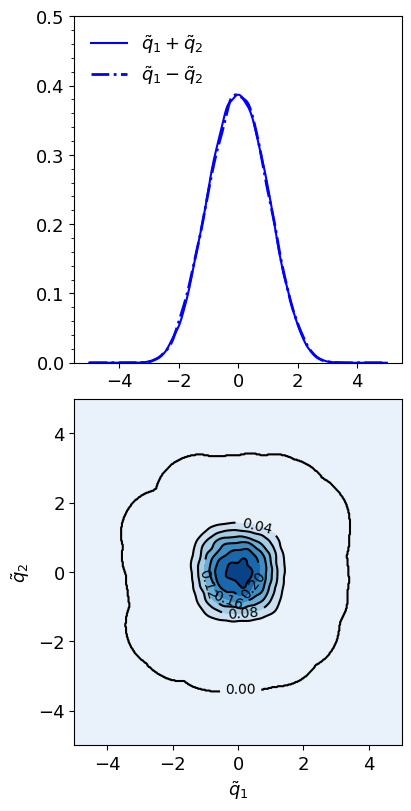

In [28]:
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(4, 8))
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
# Plot the data with labels for the legend
line1, = axs[0].plot(x, rho_data.numpy()[..., 0], c='b', ls='-', label=r'$\tilde{q}_1+\tilde{q}_2$')
line2, = axs[0].plot(x, rho_data.numpy()[..., 1], c='b', ls='-.', lw = 2, label=r'$\tilde{q}_1-\tilde{q}_2$')

# Creating the legend
legend = axs[0].legend(loc=2,frameon=False)

# Setting the y-axis limits
axs[0].set_ylim(0, 0.5)
# pdf = axs[0].plot(x, rho_data.numpy())
# legend = axs[0].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0].set_ylim(0,0.5)
# axs[0].set_title('Target PDF of Sum and Difference')

xmin, xmax = -5, 5
ymin, ymax = -5, 5
xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)
cfset = axs[1].contourf(xx, yy, rho2D_data.numpy(), cmap='Blues')
cset = axs[1].contour(xx, yy, rho2D_data.numpy(), colors='k')
axs[1].clabel(cset, inline=1, fontsize=10)
axs[1].set_xlabel(r'$\tilde{q}_1$')
axs[1].set_ylabel(r'$\tilde{q}_2$') 
# axs[1].set_title('Target PDF Contours')

In [21]:
# xmin, xmax = -5, 5
# ymin, ymax = -5, 5

# xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
# fig = plt.figure(figsize=(5, 5))
# ax = fig.gca()
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

# # Contourf plot
# cfset = ax.contourf(xx, yy, rho2D_prediction0.numpy(), cmap='Blues')
# ## Or kernel density estimate plot instead of the contourf plot

# # Contour plot
# cset = ax.contour(xx, yy, rho2D_prediction0.numpy(), colors='k')
# # Label plot
# ax.clabel(cset, inline=1, fontsize=10)
# ax.set_xlabel(r'$\tilde{q}_1$')
# ax.set_ylabel(r'$\tilde{q}_2$')

# plt.show()

Text(0, 0.5, '$\\tilde{q}_2$')

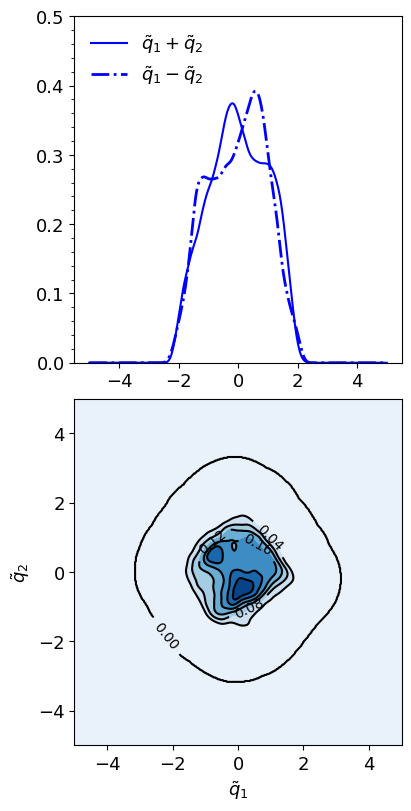

In [29]:
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(4, 8))
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
# Plot the data with labels for the legend
line1, = axs[0].plot(x, rho_prediction0.numpy()[..., 0], c='b', ls='-', label=r'$\tilde{q}_1+\tilde{q}_2$')
line2, = axs[0].plot(x, rho_prediction0.numpy()[..., 1], c='b', ls='-.', lw = 2, label=r'$\tilde{q}_1-\tilde{q}_2$')

# Creating the legend
legend = axs[0].legend(loc=2,frameon=False)

# Setting the y-axis limits
axs[0].set_ylim(0, 0.5)
# axs[0].set_title('SINN Training without combinations')


xmin, xmax = -5, 5
ymin, ymax = -5, 5
xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)
cfset = axs[1].contourf(xx, yy, rho2D_prediction0.numpy(), cmap='Blues')
cset = axs[1].contour(xx, yy, rho2D_prediction0.numpy(), colors='k')
axs[1].clabel(cset, inline=1, fontsize=10)
axs[1].set_xlabel(r'$\tilde{q}_1$')
axs[1].set_ylabel(r'$\tilde{q}_2$') 
# axs[1].set_title('SINN Training without combinations')

Text(0, 0.5, '$\\tilde{q}_2$')

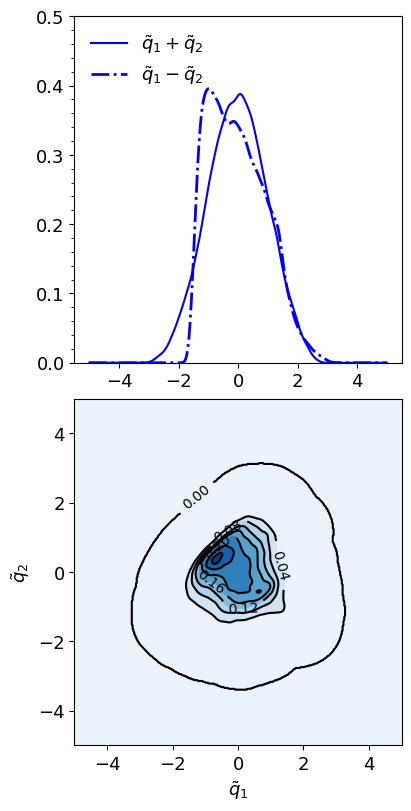

In [30]:
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(4, 8))
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
# Plot the data with labels for the legend
line1, = axs[0].plot(x, rho_prediction1.numpy()[..., 0], c='b', ls='-', label=r'$\tilde{q}_1+\tilde{q}_2$')
line2, = axs[0].plot(x, rho_prediction1.numpy()[..., 1], c='b', ls='-.', lw = 2, label=r'$\tilde{q}_1-\tilde{q}_2$')

# Creating the legend
legend = axs[0].legend(loc=2,frameon=False)

# Setting the y-axis limits
axs[0].set_ylim(0, 0.5)
# pdf = axs[0].plot(x, rho_prediction1.numpy())
# legend = axs[0].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0].set_ylim(0,0.7)
# axs[0].set_title('SINN Training with Sum')


xmin, xmax = -5, 5
ymin, ymax = -5, 5
xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)
cfset = axs[1].contourf(xx, yy, rho2D_prediction1.numpy(), cmap='Blues')
cset = axs[1].contour(xx, yy, rho2D_prediction1.numpy(), colors='k')
axs[1].clabel(cset, inline=1, fontsize=10)
axs[1].set_xlabel(r'$\tilde{q}_1$')
axs[1].set_ylabel(r'$\tilde{q}_2$') 
# axs[1].set_title('SINN Training with Sum')

Text(0, 0.5, '$\\tilde{q}_2$')

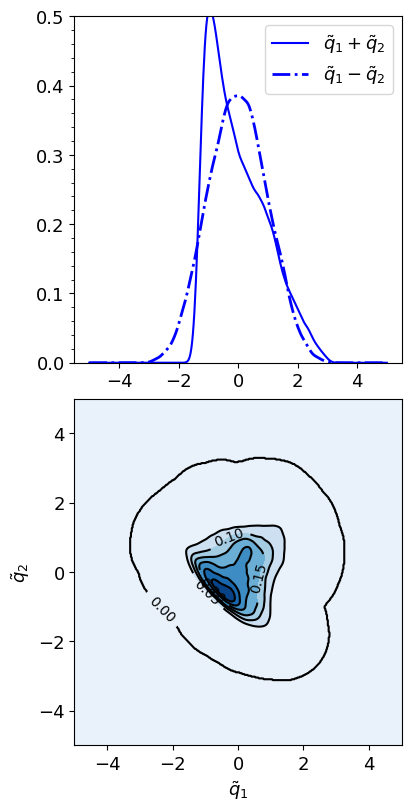

In [23]:
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(4, 8))
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
# Plot the data with labels for the legend
line1, = axs[0].plot(x, rho_prediction2.numpy()[..., 0], c='b', ls='-', label=r'$\tilde{q}_1+\tilde{q}_2$')
line2, = axs[0].plot(x, rho_prediction2.numpy()[..., 1], c='b', ls='-.', lw = 2, label=r'$\tilde{q}_1-\tilde{q}_2$')

# Creating the legend
legend = axs[0].legend(loc=1)

# Setting the y-axis limits
axs[0].set_ylim(0, 0.5)
# axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
# pdf = axs[0].plot(x, rho_prediction2.numpy())
# legend = axs[0].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0].set_ylim(0,0.5)
# axs[0].set_title('SINN Training with Difference')


xmin, xmax = -5, 5
ymin, ymax = -5, 5
xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)
cfset = axs[1].contourf(xx, yy, rho2D_prediction2.numpy(), cmap='Blues')
cset = axs[1].contour(xx, yy, rho2D_prediction2.numpy(), colors='k')
axs[1].clabel(cset, inline=1, fontsize=10)
axs[1].set_xlabel(r'$\tilde{q}_1$')
axs[1].set_ylabel(r'$\tilde{q}_2$') 
# axs[1].set_title('SINN Training with Difference')

Text(0, 0.5, '$\\tilde{q}_2$')

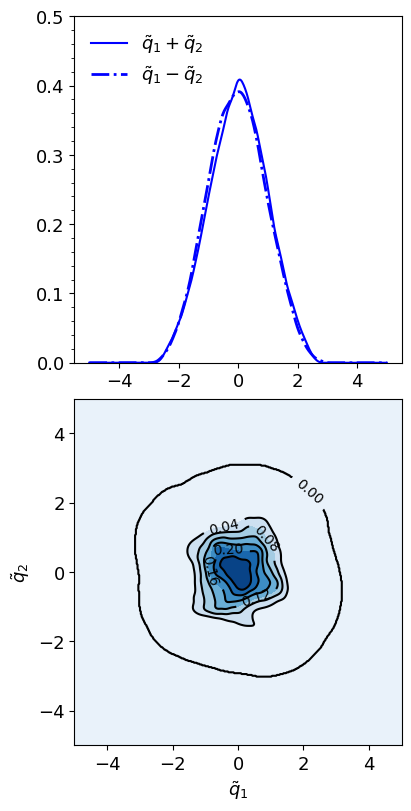

In [31]:
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(4, 8))
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
# Plot the data with labels for the legend
line1, = axs[0].plot(x, rho_prediction.numpy()[..., 0], c='b', ls='-', label=r'$\tilde{q}_1+\tilde{q}_2$')
line2, = axs[0].plot(x, rho_prediction.numpy()[..., 1], c='b', ls='-.', lw = 2, label=r'$\tilde{q}_1-\tilde{q}_2$')

# Creating the legend
legend = axs[0].legend(loc=2,frameon=False)

# Setting the y-axis limits
axs[0].set_ylim(0, 0.5)
# pdf = axs[0].plot(x, rho_prediction.numpy())
# legend = axs[0].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0].set_ylim(0,0.5)
# axs[0].set_title('SINN Training with Sum and Difference')


xmin, xmax = -5, 5
ymin, ymax = -5, 5
xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)
cfset = axs[1].contourf(xx, yy, rho2D_prediction.numpy(), cmap='Blues')
cset = axs[1].contour(xx, yy, rho2D_prediction.numpy(), colors='k')
axs[1].clabel(cset, inline=1, fontsize=10)
axs[1].set_xlabel(r'$\tilde{q}_1$')
axs[1].set_ylabel(r'$\tilde{q}_2$') 
# axs[1].set_title('SINN Training with Sum and Difference')

In [32]:
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred1,_= AWmodel_2input_1pair(ran_input)
Pred2,_= AWmodel_2input_2pair(ran_input)
Pred3,_= AWmodel_2input_3pair(ran_input)
    
# Test: plot the PDF of sum and difference of two trajectories generated by SINN
rho_data =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
rho_prediction1 = StatLoss.gauss_kde6(Pred1[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
rho_prediction2 = StatLoss.gauss_kde6(Pred2[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
rho_prediction3 = StatLoss.gauss_kde6(Pred3[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()

# Test: 2D PDF contour of target and SINN output
rho2D_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
rho2D_prediction1 = StatLoss.gauss_kde2D(Pred1[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
rho2D_prediction2 = StatLoss.gauss_kde2D(Pred2[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
rho2D_prediction3 = StatLoss.gauss_kde2D(Pred3[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()

In [ ]:
fig, axs = plt.subplots(2,4, constrained_layout=True, figsize=(16, 8))
pdf = axs[0,0].plot(x, rho_data.numpy())
legend = axs[0,0].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$',r'$\tilde{q}_1+2\tilde{q}_2$', r'$\tilde{q}_1-2\tilde{q}_2$',r'$2\tilde{q}_1+\tilde{q}_2$', r'$2\tilde{q}_1-\tilde{q}_2$'), loc=1)
axs[0,0].set_ylim(0,0.7)
axs[0,0].set_title('Target PDF of Sum and Difference')

pdf = axs[0,1].plot(x, rho_prediction1.numpy())
legend = axs[0,1].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$',r'$\tilde{q}_1+2\tilde{q}_2$', r'$\tilde{q}_1-2\tilde{q}_2$',r'$2\tilde{q}_1+\tilde{q}_2$', r'$2\tilde{q}_1-\tilde{q}_2$'), loc=1)
axs[0,1].set_ylim(0,0.7)
axs[0,1].set_title('SINN Training with 1 pair')

pdf = axs[0,2].plot(x, rho_prediction2.numpy())
legend = axs[0,2].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$',r'$\tilde{q}_1+2\tilde{q}_2$', r'$\tilde{q}_1-2\tilde{q}_2$',r'$2\tilde{q}_1+\tilde{q}_2$', r'$2\tilde{q}_1-\tilde{q}_2$'), loc=1)
axs[0,2].set_ylim(0,0.7)
axs[0,2].set_title('SINN Training with 2 pairs')

pdf = axs[0,3].plot(x, rho_prediction3.numpy())
legend = axs[0,3].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$',r'$\tilde{q}_1+2\tilde{q}_2$', r'$\tilde{q}_1-2\tilde{q}_2$',r'$2\tilde{q}_1+\tilde{q}_2$', r'$2\tilde{q}_1-\tilde{q}_2$'), loc=1)
axs[0,3].set_ylim(0,0.7)
axs[0,3].set_title('SINN Training with 3 pairs')





xmin, xmax = -5, 5
ymin, ymax = -5, 5
xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
axs[1,0].set_xlim(xmin, xmax)
axs[1,0].set_ylim(ymin, ymax)
cfset = axs[1,0].contourf(xx, yy, rho2D_data.numpy(), cmap='Blues')
cset = axs[1,0].contour(xx, yy, rho2D_data.numpy(), colors='k')
axs[1,0].clabel(cset, inline=1, fontsize=10)
axs[1,0].set_xlabel(r'$\tilde{q}_1$')
axs[1,0].set_ylabel(r'$\tilde{q}_2$') 
axs[1,0].set_title('Target PDF Contours')

cfset = axs[1,1].contourf(xx, yy, rho2D_prediction1.numpy(), cmap='Blues')
cset = axs[1,1].contour(xx, yy, rho2D_prediction1.numpy(), colors='k')
axs[1,1].set_xlim(xmin, xmax)
axs[1,1].set_ylim(ymin, ymax)
axs[1,1].clabel(cset, inline=1, fontsize=10)
axs[1,1].set_xlabel(r'$\tilde{q}_1$')
axs[1,1].set_ylabel(r'$\tilde{q}_2$') 
axs[1,1].set_title('SINN Training with 1 pair')

cfset = axs[1,2].contourf(xx, yy, rho2D_prediction2.numpy(), cmap='Blues')
cset = axs[1,2].contour(xx, yy, rho2D_prediction2.numpy(), colors='k')
axs[1,2].set_xlim(xmin, xmax)
axs[1,2].set_ylim(ymin, ymax)
axs[1,2].clabel(cset, inline=1, fontsize=10)
axs[1,2].set_xlabel(r'$\tilde{q}_1$')
axs[1,2].set_ylabel(r'$\tilde{q}_2$') 
axs[1,2].set_title('SINN Training with 2 pairs')

cfset = axs[1,3].contourf(xx, yy, rho2D_prediction3.numpy(), cmap='Blues')
cset = axs[1,3].contour(xx, yy, rho2D_prediction3.numpy(), colors='k')
axs[1,3].set_xlim(xmin, xmax)
axs[1,3].set_ylim(ymin, ymax)
axs[1,3].clabel(cset, inline=1, fontsize=10)
axs[1,3].set_xlabel(r'$\tilde{q}_1$')
axs[1,3].set_ylabel(r'$\tilde{q}_2$') 
axs[1,3].set_title('SINN Training with 3 pairs')


Text(0, 0.5, '$\\tilde{q}_2$')

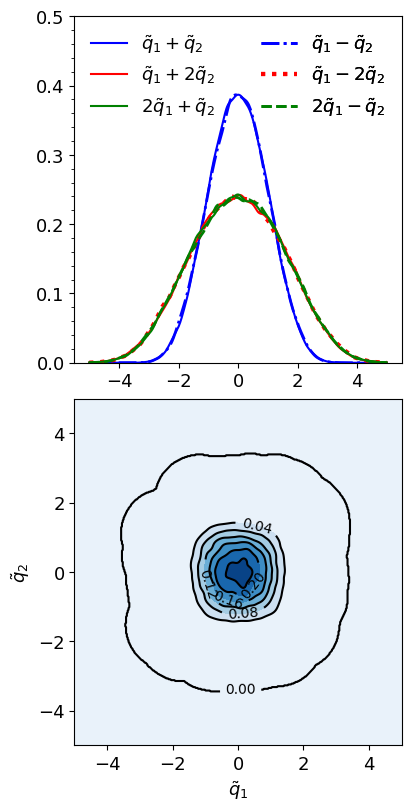

In [34]:
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(4, 8))
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
line1, =axs[0].plot(x, rho_data.numpy()[...,0], c='b',ls='-',label=r'$\tilde{q}_1+\tilde{q}_2$')
line2, =axs[0].plot(x, rho_data.numpy()[...,1], c='b',ls='-.',lw=2,label=r'$\tilde{q}_1-\tilde{q}_2$')
line3, =axs[0].plot(x, rho_data.numpy()[...,2], c='r',ls='-',label=r'$\tilde{q}_1+2\tilde{q}_2$')
line4, =axs[0].plot(x, rho_data.numpy()[...,3], c='r',ls=':',lw=3,label=r'$\tilde{q}_1-2\tilde{q}_2$')
line5, =axs[0].plot(x, rho_data.numpy()[...,4], c='g',ls='-',label=r'$2\tilde{q}_1+\tilde{q}_2$')
line6, =axs[0].plot(x, rho_data.numpy()[...,5], c='g',ls='--',lw=2,label=r'$2\tilde{q}_1-\tilde{q}_2$')
# Creating separate legends
legend1 = axs[0].legend(handles=[line1, line3, line5], loc='upper left',frameon=False)
legend2 = axs[0].legend(handles=[line2, line4, line6], loc='upper right',frameon=False)


# Adding legends to the plot
axs[0].add_artist(legend1)
axs[0].add_artist(legend2)
# axs[0].add_artist(legend3)
axs[0].set_ylim(0,0.5)
# axs[0].set_title('Target PDF of Sum and Difference')


xmin, xmax = -5, 5
ymin, ymax = -5, 5
xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)
cfset = axs[1].contourf(xx, yy, rho2D_data.numpy(), cmap='Blues')
cset = axs[1].contour(xx, yy, rho2D_data.numpy(), colors='k')
axs[1].clabel(cset, inline=1, fontsize=10)
axs[1].set_xlabel(r'$\tilde{q}_1$')
axs[1].set_ylabel(r'$\tilde{q}_2$') 
# axs[1].set_title('Target PDF Contours')

Text(0, 0.5, '$\\tilde{q}_2$')

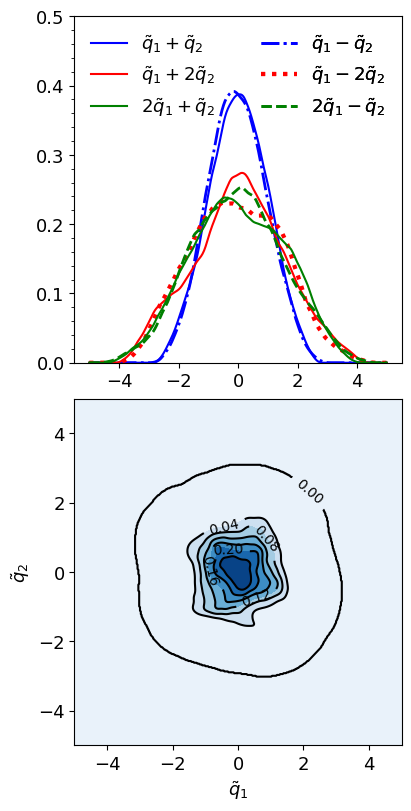

In [35]:
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(4, 8))
# pdf = axs[0].plot(x, rho_prediction1.numpy())
# legend = axs[0].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$',r'$\tilde{q}_1+2\tilde{q}_2$', r'$\tilde{q}_1-2\tilde{q}_2$',r'$2\tilde{q}_1+\tilde{q}_2$', r'$2\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0].set_ylim(0,0.7)
# axs[0].set_title('SINN Training with 1 pair')
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
line1, =axs[0].plot(x, rho_prediction1.numpy()[...,0], c='b',ls='-',label=r'$\tilde{q}_1+\tilde{q}_2$')
line2, =axs[0].plot(x, rho_prediction1.numpy()[...,1], c='b',ls='-.',lw=2,label=r'$\tilde{q}_1-\tilde{q}_2$')
line3, =axs[0].plot(x, rho_prediction1.numpy()[...,2], c='r',ls='-',label=r'$\tilde{q}_1+2\tilde{q}_2$')
line4, =axs[0].plot(x, rho_prediction1.numpy()[...,3], c='r',ls=':',lw=3,label=r'$\tilde{q}_1-2\tilde{q}_2$')
line5, =axs[0].plot(x, rho_prediction1.numpy()[...,4], c='g',ls='-',label=r'$2\tilde{q}_1+\tilde{q}_2$')
line6, =axs[0].plot(x, rho_prediction1.numpy()[...,5], c='g',ls='--',lw=2,label=r'$2\tilde{q}_1-\tilde{q}_2$')
# Creating separate legends
legend1 = axs[0].legend(handles=[line1, line3, line5], loc='upper left',frameon=False)
legend2 = axs[0].legend(handles=[line2, line4, line6], loc='upper right',frameon=False)


# Adding legends to the plot
axs[0].add_artist(legend1)
axs[0].add_artist(legend2)
# axs[0].add_artist(legend3)
axs[0].set_ylim(0,0.5)

cfset = axs[1].contourf(xx, yy, rho2D_prediction.numpy(), cmap='Blues')
cset = axs[1].contour(xx, yy, rho2D_prediction.numpy(), colors='k')
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)
axs[1].clabel(cset, inline=1, fontsize=10)
axs[1].set_xlabel(r'$\tilde{q}_1$')
axs[1].set_ylabel(r'$\tilde{q}_2$') 
# axs[1].set_title('SINN Training with 1 pair')

Text(0, 0.5, '$\\tilde{q}_2$')

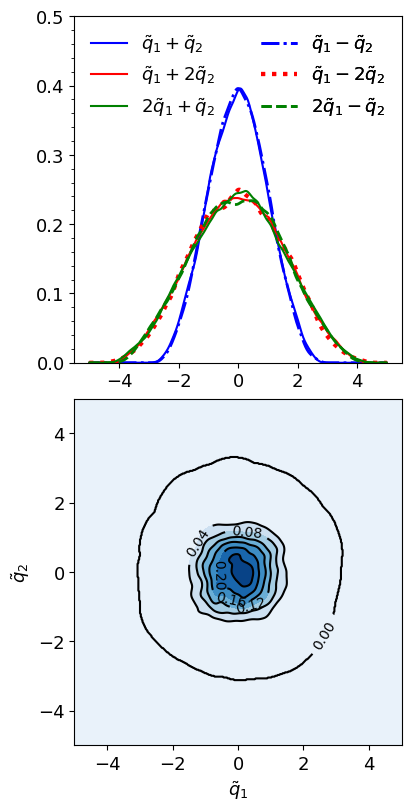

In [36]:
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(4, 8))
# pdf = axs[0].plot(x, rho_prediction2.numpy())
# legend = axs[0].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$',r'$\tilde{q}_1+2\tilde{q}_2$', r'$\tilde{q}_1-2\tilde{q}_2$',r'$2\tilde{q}_1+\tilde{q}_2$', r'$2\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0].set_ylim(0,0.7)
# # axs[0].set_title('SINN Training with 2 pairs')
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
line1, =axs[0].plot(x, rho_prediction2.numpy()[...,0], c='b',ls='-',label=r'$\tilde{q}_1+\tilde{q}_2$')
line2, =axs[0].plot(x, rho_prediction2.numpy()[...,1], c='b',ls='-.',lw=2,label=r'$\tilde{q}_1-\tilde{q}_2$')
line3, =axs[0].plot(x, rho_prediction2.numpy()[...,2], c='r',ls='-',label=r'$\tilde{q}_1+2\tilde{q}_2$')
line4, =axs[0].plot(x, rho_prediction2.numpy()[...,3], c='r',ls=':',lw=3,label=r'$\tilde{q}_1-2\tilde{q}_2$')
line5, =axs[0].plot(x, rho_prediction2.numpy()[...,4], c='g',ls='-',label=r'$2\tilde{q}_1+\tilde{q}_2$')
line6, =axs[0].plot(x, rho_prediction2.numpy()[...,5], c='g',ls='--',lw=2,label=r'$2\tilde{q}_1-\tilde{q}_2$')
# Creating separate legends
legend1 = axs[0].legend(handles=[line1, line3, line5], loc='upper left',frameon=False)
legend2 = axs[0].legend(handles=[line2, line4, line6], loc='upper right',frameon=False)


# Adding legends to the plot
axs[0].add_artist(legend1)
axs[0].add_artist(legend2)
# axs[0].add_artist(legend3)
axs[0].set_ylim(0,0.5)

cfset = axs[1].contourf(xx, yy, rho2D_prediction2.numpy(), cmap='Blues')
cset = axs[1].contour(xx, yy, rho2D_prediction2.numpy(), colors='k')
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)
axs[1].clabel(cset, inline=1, fontsize=10)
axs[1].set_xlabel(r'$\tilde{q}_1$')
axs[1].set_ylabel(r'$\tilde{q}_2$') 
# axs[1].set_title('SINN Training with 2 pairs')

Text(0, 0.5, '$\\tilde{q}_2$')

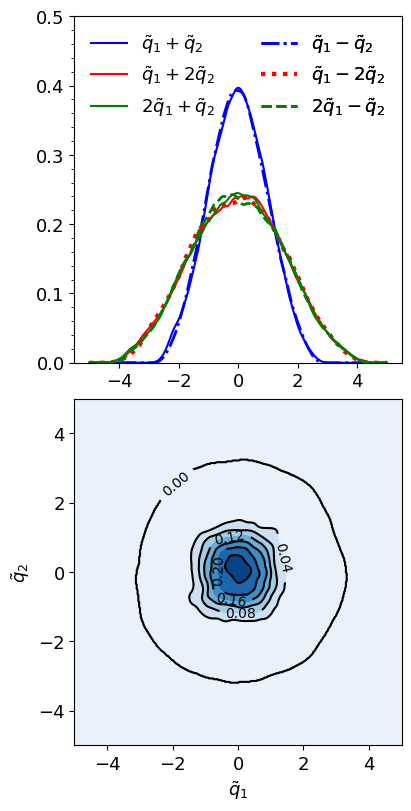

In [37]:
fig, axs = plt.subplots(2,1, constrained_layout=True, figsize=(4, 8))
# pdf = axs[0].plot(x, rho_prediction3.numpy())
# legend = axs[0].legend(iter(pdf), (r'$\tilde{q}_1+\tilde{q}_2$', r'$\tilde{q}_1-\tilde{q}_2$',r'$\tilde{q}_1+2\tilde{q}_2$', r'$\tilde{q}_1-2\tilde{q}_2$',r'$2\tilde{q}_1+\tilde{q}_2$', r'$2\tilde{q}_1-\tilde{q}_2$'), loc=1)
# axs[0].set_ylim(0,0.7)
# axs[0].set_title('SINN Training with 3 pairs')
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
line1, =axs[0].plot(x, rho_prediction3.numpy()[...,0], c='b',ls='-',label=r'$\tilde{q}_1+\tilde{q}_2$')
line2, =axs[0].plot(x, rho_prediction3.numpy()[...,1], c='b',ls='-.',lw=2,label=r'$\tilde{q}_1-\tilde{q}_2$')
line3, =axs[0].plot(x, rho_prediction3.numpy()[...,2], c='r',ls='-',label=r'$\tilde{q}_1+2\tilde{q}_2$')
line4, =axs[0].plot(x, rho_prediction3.numpy()[...,3], c='r',ls=':',lw=3,label=r'$\tilde{q}_1-2\tilde{q}_2$')
line5, =axs[0].plot(x, rho_prediction3.numpy()[...,4], c='g',ls='-',label=r'$2\tilde{q}_1+\tilde{q}_2$')
line6, =axs[0].plot(x, rho_prediction3.numpy()[...,5], c='g',ls='--',lw=2,label=r'$2\tilde{q}_1-\tilde{q}_2$')
# Creating separate legends
legend1 = axs[0].legend(handles=[line1, line3, line5], loc='upper left',frameon=False)
legend2 = axs[0].legend(handles=[line2, line4, line6], loc='upper right',frameon=False)


# Adding legends to the plot
axs[0].add_artist(legend1)
axs[0].add_artist(legend2)
# axs[0].add_artist(legend3)
axs[0].set_ylim(0,0.5)

cfset = axs[1].contourf(xx, yy, rho2D_prediction3.numpy(), cmap='Blues')
cset = axs[1].contour(xx, yy, rho2D_prediction3.numpy(), colors='k')
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)
axs[1].clabel(cset, inline=1, fontsize=10)
axs[1].set_xlabel(r'$\tilde{q}_1$')
axs[1].set_ylabel(r'$\tilde{q}_2$') 
# axs[1].set_title('SINN Training with 3 pairs')

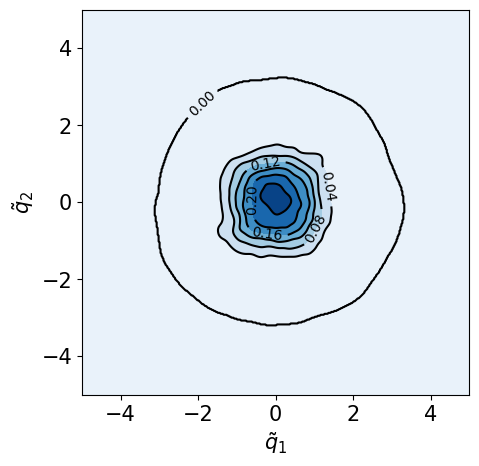

In [35]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, rho2D_prediction3.numpy(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, rho2D_prediction3.numpy(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$\tilde{q}_1$')
ax.set_ylabel(r'$\tilde{q}_2$')

plt.show()